### In the baylor dataset, investigate PHQ prediction problem with

- Textcall loc features (mobile sensing)
- With ipsn features added

In [1]:
import os
import numpy as np
np.random.seed(seed=42)
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2,style='whitegrid')
from statannot import add_stat_annotation
from scipy.stats import pearsonr, spearmanr
from sklearn.impute import KNNImputer
import time

Colormap for heatmp contrast

In [2]:
from matplotlib.colors import LinearSegmentedColormap
cmap_ls = LinearSegmentedColormap.from_list(
    name='test', 
    colors=['red','white','green','white','red']
)
cmap_div = sns.diverging_palette(230, 20, as_cmap=True)
from matplotlib.lines import Line2D

### Feature files

In [3]:
call_feat_datafile    = r'Data/subj_call_res_pd.csv'
sms_feat_datafile     = r'Data/subj_sms_res_pd.csv'
callsms_feat_datafile = r'Data/subj_callsms_res_pd.csv'
loc_feat_datafile     = r'Data/subj_loc_feat.csv'

Information about subjects

In [4]:
baylor_phq_group = pd.read_excel('Data/phq.xlsx')[['Subj','PHQ-sum','Study Group']]
baylor_phq_group['subj'] = baylor_phq_group['Subj'].apply(lambda x:'baylor'+str(x))
group_map = {'Employee':'Healthy','depression':'Depression','Psychosis':'Psychosis',
            'Depression':'Depression','psychosis':'Psychosis'}
baylor_phq_group['Group']= baylor_phq_group['Study Group'].apply(lambda x:group_map[x])
baylor_phq_group.head()

,Subj,PHQ-sum,Study Group,subj,Group
0,1,5,Employee,baylor1,Healthy
1,2,0,Employee,baylor2,Healthy
2,3,3,Employee,baylor3,Healthy
3,4,4,Employee,baylor4,Healthy
4,5,1,Employee,baylor5,Healthy


In [5]:
baylor_call_feat_data   = pd.read_csv(call_feat_datafile,index_col=0)
baylor_sms_feat_data    = pd.read_csv(sms_feat_datafile,index_col=0)
baylor_callsms_feat_data= pd.read_csv(callsms_feat_datafile,index_col=0)
baylor_loc_feat_data    = pd.read_csv(loc_feat_datafile,index_col=0).rename({'monitoring_period':'gps_monitoring_period'},
                                                                    axis=1).drop('phq_date',axis=1)

Number of data present

In [6]:
baylor_call_feat_data.shape, baylor_sms_feat_data.shape, baylor_callsms_feat_data.shape, baylor_loc_feat_data.shape

((26, 9), (25, 9), (26, 8), (19, 8))

There is no missing data

In [7]:
baylor_call_feat_data.isna().sum().sum(), baylor_sms_feat_data.isna().sum().sum(), baylor_callsms_feat_data.isna().sum().sum(), baylor_loc_feat_data.isna().sum().sum()

(0, 0, 0, 0)

In [8]:
common_cols        = ['subj','phq_date','PHQ-sum','dataset']

call_feat_cols    = np.setdiff1d(baylor_call_feat_data.columns,common_cols)
sms_feat_cols     = np.setdiff1d(baylor_sms_feat_data.columns,common_cols)
callsms_feat_cols = np.setdiff1d(baylor_callsms_feat_data.columns,common_cols)
loc_feat_cols     = np.setdiff1d(baylor_loc_feat_data.columns,np.union1d(common_cols,['gps_monitoring_period']))

In [9]:
baylor_call_feat_data.shape, baylor_sms_feat_data.shape, baylor_callsms_feat_data.shape, baylor_loc_feat_data.shape

((26, 9), (25, 9), (26, 8), (19, 8))

In [10]:
baylor_loc_feat_data_ = baylor_loc_feat_data.merge(baylor_phq_group[['subj','Group']],
                                                 on='subj')
print(baylor_loc_feat_data_.shape)

(19, 9)


### Audio-based network features

In [11]:
ipsn_networksize_pd         = pd.read_csv(r'Data/ipsn_perday.csv',index_col=0)
ipsn_networksize_pd['subj'] = ipsn_networksize_pd['subj'].apply(lambda x:'baylor'+str(x)) 
print(ipsn_networksize_pd.shape)
ipsn_networksize_pd.head()

(112, 5)


,subj,day,num_speaker_scaled,PHQ-sum,Group
0,baylor1,20180325,6.387251,5,Healthy
1,baylor1,20180326,10.126107,5,Healthy
2,baylor1,20180329,11.247344,5,Healthy
3,baylor2,20180331,7.160889,0,Healthy
4,baylor2,20180401,8.078240,0,Healthy


In [12]:
ipsn_topspeaker12_pd         = pd.read_csv(r'Data/topspeaker12_speechcount_pd.csv',index_col=0)
ipsn_topspeaker12_pd['subj'] = ipsn_topspeaker12_pd['subj'].apply(lambda x:'baylor'+str(x)) 
ipsn_topspeaker12_pd.head()

,subj,day,mainsecond_speaker_speechcount
0,baylor1,20180325,17434.252
1,baylor1,20180326,19987.049
2,baylor1,20180329,10435.320
3,baylor2,20180331,5682.287
4,baylor2,20180401,4611.251


In [13]:
ipsn_common_cols = ['subj','day']

ipsn_allfeat_pd  = ipsn_networksize_pd.merge(ipsn_topspeaker12_pd,on=ipsn_common_cols,
                                           how='inner')
print(len(ipsn_allfeat_pd.subj.unique()))
ipsn_allfeat_pd.head()

30


,subj,day,num_speaker_scaled,PHQ-sum,Group,mainsecond_speaker_speechcount
0,baylor1,20180325,6.387251,5,Healthy,17434.252
1,baylor1,20180326,10.126107,5,Healthy,19987.049
2,baylor1,20180329,11.247344,5,Healthy,10435.320
3,baylor2,20180331,7.160889,0,Healthy,5682.287
4,baylor2,20180401,8.078240,0,Healthy,4611.251


### Dyadic features

In [14]:
ipsn_dyadic_feat_pd = pd.read_csv('Data/subj_dyadic_feat_all.csv',index_col=0)
ipsn_dyadic_feat_pd['subj'] = ipsn_dyadic_feat_pd['subj'].apply(lambda x:'baylor'+str(x))

### Merge features

In [15]:
ipsn_nondyadic_variables = ['num_speaker_scaled','mainsecond_speaker_speechcount']
ipsn_subjfeat  = ipsn_allfeat_pd.groupby('subj')[ipsn_nondyadic_variables].agg(['mean']).reset_index()
ipsn_subjfeat.columns = [x[0]+'_'+x[1] if len(x[1])>1 else x[0] for x in ipsn_subjfeat.columns.to_flat_index()]

In [16]:
ipsn_subjfeat.head()

,subj,num_speaker_scaled_mean,mainsecond_speaker_speechcount_mean
0,baylor1,9.253567,15952.207000
1,baylor10,7.174257,5233.357250
2,baylor12,11.598839,10002.327250
3,baylor13,8.194818,8461.825500
4,baylor14,10.134045,5520.909167


In [17]:
ipsn_dyadic_variables = ['responsetime']
ipsn_subj_feat_all    = ipsn_subjfeat.merge(ipsn_dyadic_feat_pd[ipsn_dyadic_variables+['subj']],on='subj',how='outer')

In [18]:
ipsn_subj_feat_all.head()

,subj,num_speaker_scaled_mean,mainsecond_speaker_speechcount_mean,responsetime
0,baylor1,9.253567,15952.207000,0.428565
1,baylor10,7.174257,5233.357250,1.353702
2,baylor12,11.598839,10002.327250,0.945200
3,baylor13,8.194818,8461.825500,1.014737
4,baylor14,10.134045,5520.909167,NaN


In [19]:
ipsn_all_variables = ipsn_nondyadic_variables + ipsn_dyadic_variables

In [20]:
ipsn_all_variables

['num_speaker_scaled', 'mainsecond_speaker_speechcount', 'responsetime']

In [21]:
ipsn_subj_feat_all.shape

(30, 4)

### Research Question1: Can depression severity be predicted from mobile sensing data

#### PHQ score prediction

In [22]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge, RidgeCV
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import LeaveOneOut, KFold, GridSearchCV
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, fbeta_score,\
                                mean_absolute_error, confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from statsmodels.stats.outliers_influence import variance_inflation_factor    
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import make_scorer
#ordinal regression model
# all-threshold, immediate-threshold, squared-error variants
from mord import LogisticAT, LogisticIT, LogisticSE, LAD, OrdinalRidge

In [23]:
#predict PHQ score in LOPO setting using text/call info

In [24]:
minmax_scaler   = MinMaxScaler()
standard_scaler = StandardScaler()

Depression Levels

0-4 : None
5-9 : Mild
10-14: Moderate
15-19: Moderately severe
20-27: Severe


In [25]:
def rmse_neg(x,y):
    return -np.sqrt(mean_squared_error(x,y))

In [26]:
# Depression severity prediction model 

lopo         = LeaveOneOut()
kfold        = KFold(n_splits=5)
imputer_knn  = KNNImputer(n_neighbors=3)

sel_split        = lopo
inner_split_lopo = LeaveOneOut()


ridge_cv = RidgeCV(alphas=[ 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
                   scoring='neg_mean_squared_error')

def return_lopo_prediction(feat_data,label_data,subj_data,fit_intercept=False,corr_p_thr=0.05):

    sel_scaler = standard_scaler

    sel_clf    = ridge_cv 
  
    true_label = []
    pred_label = []
    pred_baseline_label = []
    subj_name           = []
    num_feat_selected   = []
    all_clf             = []

    for train_idx, test_idx in sel_split.split(feat_data,label_data):
        train_feat = feat_data.iloc[train_idx,:]
        test_feat  = feat_data.iloc[test_idx,:]
        
        train_label= label_data.iloc[train_idx]
        test_label = label_data.iloc[test_idx]
        
        test_subj  = subj_data.iloc[test_idx]
        
        #fill nan if any
        train_feat  = imputer_knn.fit_transform(train_feat)
        test_feat   = imputer_knn.transform(test_feat)
        
        sel_clf.fit(train_feat,train_label)
        num_feat_selected.append(train_feat.shape[1])
        pred_ = sel_clf.predict(test_feat)
      
        #max phq is 0-27 -- floor ceiling to that limit
        pred_ = [np.max([np.min([x,27]),0]) for x in pred_]

        true_label.append(test_label)
        pred_label.append(pred_)
        pred_baseline_label.append([np.mean(train_label)]*len(pred_))
        subj_name.append(test_subj)
        all_clf.append(sel_clf)
        

    true_label_np          = np.concatenate(true_label)
    pred_label_np          = np.concatenate(pred_label)
    pred_baseline_label_np = np.concatenate(pred_baseline_label)
    test_subj_np           = np.concatenate(subj_name)

    rmse_pred          = np.sqrt(mean_squared_error(true_label_np,pred_label_np))
    rmse_pred_baseline = np.sqrt(mean_squared_error(true_label_np,pred_baseline_label_np))
    
    #find performance for different participant types
    low_idx  = np.where(pred_label_np <= 15)[0]
    high_idx = np.where(pred_label_np > 15)[0] 
    
    rmse_pred_low           = np.sqrt(mean_squared_error(true_label_np[low_idx],pred_label_np[low_idx]))
    rmse_pred_high          = np.sqrt(mean_squared_error(true_label_np[high_idx],pred_label_np[high_idx]))
      
    return rmse_pred, rmse_pred_baseline, true_label_np, pred_label_np, pred_baseline_label_np, test_subj_np,\
                rmse_pred_low, rmse_pred_high, all_clf

In [27]:
loc_feat_cols_sel = ['overall_clust_normalized_entropy',
                     'total_dist_norm_pts','overall_location_variance']

In [28]:
groups_to_include = ['num_partner_perday_outgoing_','num_partner_perday_incoming_',
                     'assymetrycoeff_','skewnesscoeff_','num_']

In [29]:
call_feat_cols_sel =   np.setdiff1d( [ x + 'call' for x in groups_to_include] + ['avgdur_call'] , [] )

In [30]:
sms_feat_cols_sel =  [ x + 'sms' for x in groups_to_include]

In [31]:
callsms_feat_cols_sel = [ x + 'callsms' for x in groups_to_include]

In [32]:
ipsn_variables_sel     = ['num_speaker_scaled_mean',
                         'mainsecond_speaker_speechcount_mean','responsetime']

In [33]:
baylor_mobilesensing_feat_data = baylor_call_feat_data.merge(baylor_sms_feat_data,on=common_cols,how='outer').\
                                            merge(baylor_callsms_feat_data,on=common_cols,how='outer').fillna(0).\
    merge(baylor_loc_feat_data_,on=['subj','PHQ-sum','dataset'],how='outer').\
                                        merge(ipsn_subj_feat_all,on=['subj'],how='outer')
                                        

baylor_mobilesensing_feat_data = baylor_mobilesensing_feat_data[~baylor_mobilesensing_feat_data['PHQ-sum'].isna()]
baylor_mobilesensing_feat_data.shape

(26, 29)

In [34]:
ipsn_variables_sel

['num_speaker_scaled_mean',
 'mainsecond_speaker_speechcount_mean',
 'responsetime']

### Correlation between features and PHQ-9 scores

In [35]:
mobilesensing_feat_cols = np.setdiff1d(np.union1d(np.union1d(np.union1d(call_feat_cols_sel,sms_feat_cols_sel),
                                     callsms_feat_cols_sel),loc_feat_cols_sel),['num_days'])
mobilesens_ipsn_variables = np.union1d(mobilesensing_feat_cols, ipsn_variables_sel)

In [36]:
#compute correlation between features and labels
feat_corr = []

for each_feat in mobilesens_ipsn_variables:
    
    feat_val  = baylor_mobilesensing_feat_data[each_feat].values
    label_val = baylor_mobilesensing_feat_data['PHQ-sum'].values
    
    feat_val_ = feat_val[~np.isnan(feat_val)]
    label_val_= label_val[~np.isnan(feat_val)]
    
    corr_val, corr_p = pearsonr(feat_val_, label_val_)
    
    if(each_feat.split('_')[-1] in ['call','sms','callsms']):
        feat_category = each_feat.split('_')[-1]
    else:
        feat_category  = 'loc/ipsn'
    
    feat_corr.append({'feat':each_feat,
                                      'corr_val':corr_val,
                                      'abs_corr':np.abs(corr_val),
                                      'corr_p':corr_p,
                                     'num_support_points':len(feat_val_),
                                     'category':feat_category})
    
feat_corr_pd = pd.DataFrame(feat_corr).sort_values(by='category')

In [37]:
feat_corr_pd.head()

,feat,corr_val,abs_corr,corr_p,num_support_points,category
0,assymetrycoeff_call,0.290139,0.290139,0.150488,26,call
18,skewnesscoeff_call,0.308995,0.308995,0.124550,26,call
7,num_partner_perday_incoming_call,-0.174673,0.174673,0.393411,26,call
5,num_call,-0.001958,0.001958,0.992426,26,call
10,num_partner_perday_outgoing_call,-0.065286,0.065286,0.751349,26,call


### Correlation of mobile sensing features with audio-based features

In [38]:
mobilesensing_feat_cols

array(['assymetrycoeff_call', 'assymetrycoeff_callsms',
       'assymetrycoeff_sms', 'avgdur_call', 'num_call', 'num_callsms',
       'num_partner_perday_incoming_call',
       'num_partner_perday_incoming_callsms',
       'num_partner_perday_incoming_sms',
       'num_partner_perday_outgoing_call',
       'num_partner_perday_outgoing_callsms',
       'num_partner_perday_outgoing_sms', 'num_sms',
       'overall_clust_normalized_entropy', 'overall_location_variance',
       'skewnesscoeff_call', 'skewnesscoeff_callsms', 'skewnesscoeff_sms',
       'total_dist_norm_pts'], dtype='<U35')

In [39]:
feat_rename = {'num_speaker_scaled_mean':'conversational \n network size',
 'mainsecond_speaker_speechcount_mean':'top speakers\' \n speech ratio',
 'responsetime':'response time' ,
       'num_partner_perday_incoming_call':'numpartner_incoming_call',
       'num_partner_perday_incoming_callsms':'numpartner_incoming_callsms',
       'num_partner_perday_incoming_sms':'numpartner_incoming_sms',
       'num_partner_perday_outgoing_call':'numpartner_outgoing_call',
       'num_partner_perday_outgoing_callsms':'numpartner_outgoing_callsms',
       'num_partner_perday_outgoing_sms':'numpartner_outgoing_sms',
       'overall_clust_normalized_entropy':'cluster entropy',
               'overall_location_variance':'location variance',
       'total_dist_norm_pts':'distance traveled'}

In [40]:
annot_res   = {}
heatmap_res = {}
for ipsn_feat in ipsn_variables_sel:
    curr_annot_res   = {}
    curr_heatmap_res = {}
    for mobilesens_feat in mobilesensing_feat_cols:
        curr_pair = baylor_mobilesensing_feat_data[[mobilesens_feat]+[ipsn_feat]].copy().dropna()
        curr_corr_val, curr_corr_pval   = pearsonr(curr_pair[mobilesens_feat],
                                                curr_pair[ipsn_feat])
        if(curr_corr_pval<=0.05):
            annot_str = '*'
        if(curr_corr_pval <= 0.01):
            annot_str = '**'
        if(curr_corr_pval <= 0.001):
            annot_str = '***'
        if(curr_corr_pval > 0.05):
            annot_str = ''
            
        if(mobilesens_feat in feat_rename.keys()):
            mobilesens_feat_ = feat_rename[mobilesens_feat]
        else:
            mobilesens_feat_ = mobilesens_feat
        
        if(ipsn_feat in feat_rename.keys()):
            ipsn_feat_ = feat_rename[ipsn_feat]
        else:
            ipsn_feat_ = ipsn_feat
            
        curr_annot_res[mobilesens_feat_]   = '{:.2f} {}'.format(curr_corr_val, annot_str)
        curr_heatmap_res[mobilesens_feat_] = np.round(curr_corr_val,2)
    
    annot_res[ipsn_feat_]   = curr_annot_res
    heatmap_res[ipsn_feat_] = curr_heatmap_res

annot_res_pd   = pd.DataFrame(annot_res)
heatmap_res_pd = pd.DataFrame(heatmap_res)

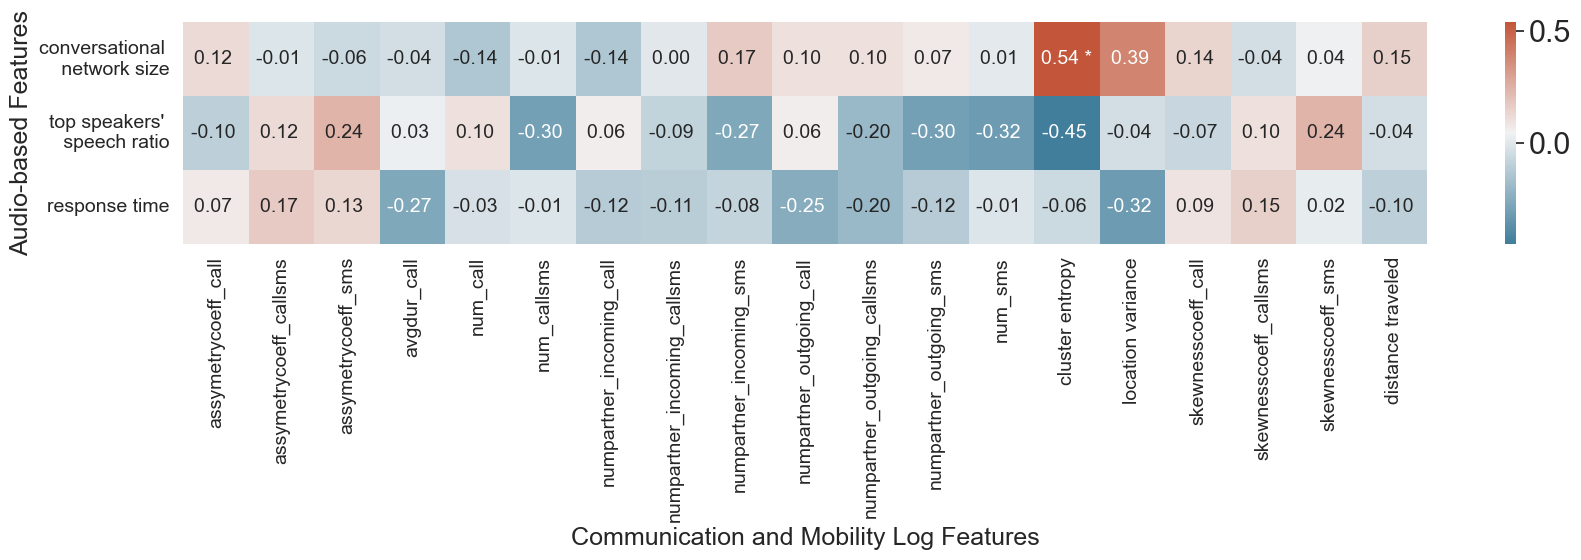

In [41]:
fig, ax = plt.subplots(figsize=(18,6))
corr_plot = sns.heatmap(heatmap_res_pd.transpose(),annot=annot_res_pd.transpose(),fmt='',
                        cmap=cmap_div,
                        annot_kws={"size":14},
                        xticklabels=True,yticklabels=True,ax=ax)
corr_plot.set_yticklabels(corr_plot.get_yticklabels(), size = 14)
corr_plot.set_xticklabels(corr_plot.get_xticklabels(), size = 14)

plt.xlabel('Communication and Mobility Log Features',fontsize=18)
plt.ylabel('Audio-based Features',fontsize=18)

plt.tight_layout()

### plot different network size

Text(0.5, 0.98, 'Average Network Size for per-day communication across different communication medium')

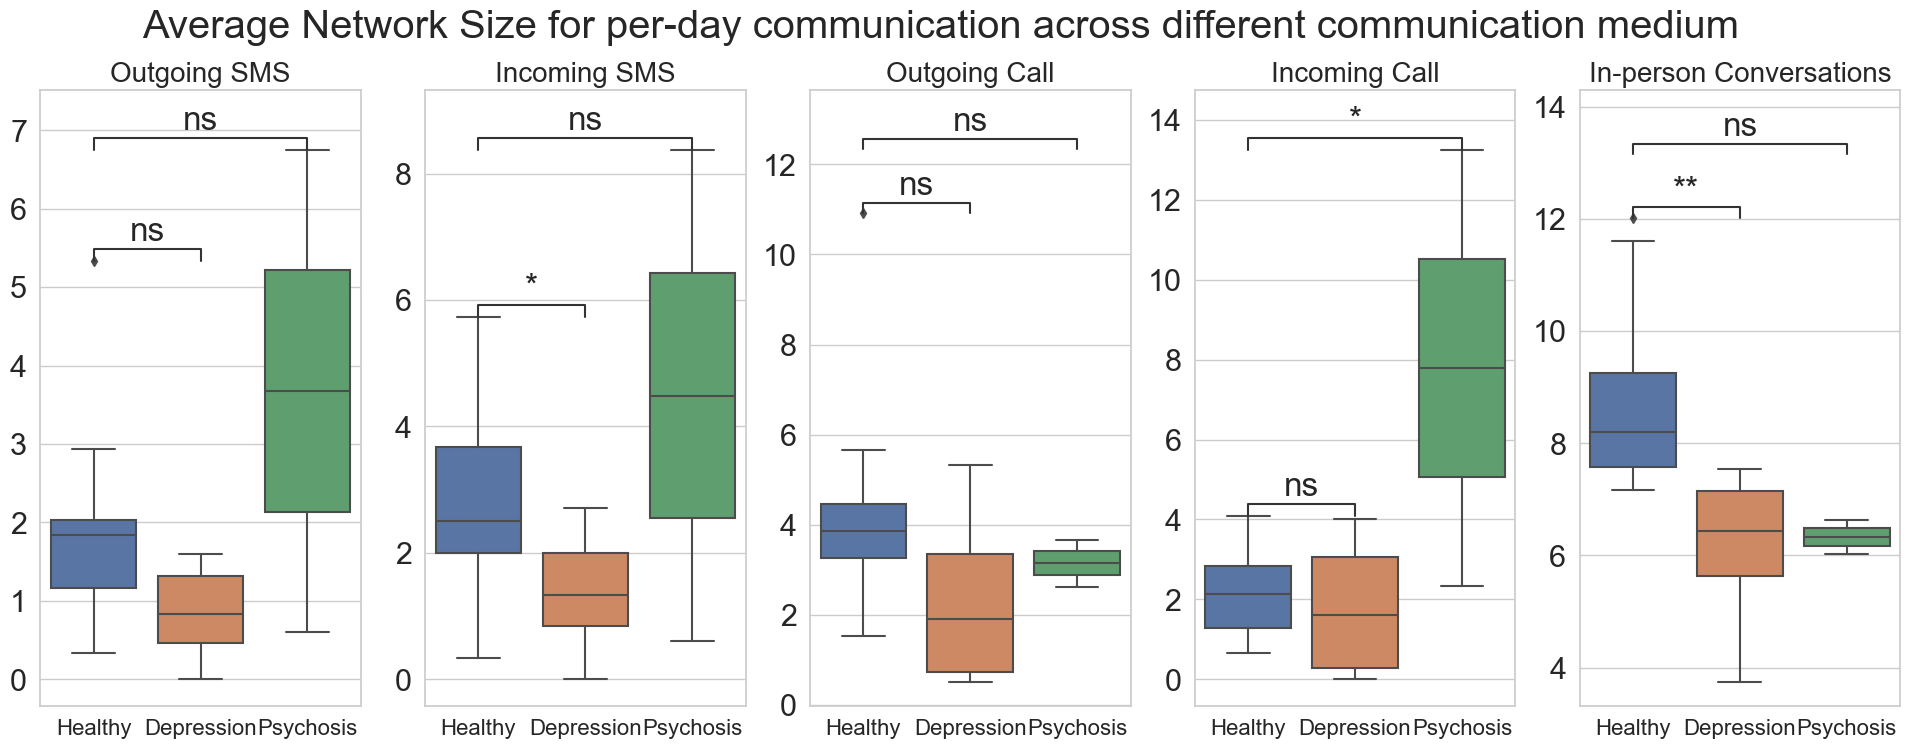

In [42]:
fig, ax = plt.subplots(1,5,figsize=(24,8))
x_order = ['Healthy','Depression','Psychosis']

variables_ = ['num_partner_perday_outgoing_sms','num_partner_perday_incoming_sms',
                   'num_partner_perday_outgoing_call','num_partner_perday_incoming_call',
                  'num_speaker_scaled_mean']

variables_name_map = {'num_partner_perday_outgoing_sms':'Outgoing SMS',
                      'num_partner_perday_incoming_sms':'Incoming SMS',
                      'num_partner_perday_outgoing_call':'Outgoing Call',
                      'num_partner_perday_incoming_call':'Incoming Call',
                      'num_speaker_scaled_mean': 'In-person Conversations'}


#Mann-Whitney-gt, t-test_ind
plot_significance = True

for idx,each_var in enumerate(variables_):
    sns.boxplot(x='Group',y=each_var,data=baylor_mobilesensing_feat_data,ax=ax[idx],
               order=x_order)
    ax[idx].set_ylabel('')
    ax[idx].set_xlabel('')
    ax[idx].set_title(variables_name_map[each_var],fontsize=20)
    
    _ = ax[idx].set_xticklabels(x_order,fontsize=16)
    
    if(plot_significance):
        test_res = add_stat_annotation(ax[idx],
                    data=baylor_mobilesensing_feat_data,
                    x='Group',y=each_var,
                    loc='inside',
                    line_offset_to_box=0,
                    box_pairs=[('Healthy','Depression'),('Healthy','Psychosis')],
                    test='t-test_ind',comparisons_correction=None,verbose=False)

    
plt.suptitle('Average Network Size for per-day communication across different communication medium')


## Depression severity prediction from different models (feature sets)

Feature input dimension: (26, 19)
RMSE of mobilesens prediction (feat:19) is: 6.80/9.64, - normalized 0.25/0.36,  corr 0.69(p=0.000)
RMSE of ipsn (feat:3) prediction is: 8.46/9.64 - normalized 0.31,  corr 0.43(p=0.028)
RMSE of combined prediction (feat:22) is: 6.07/9.64, normalized: 0.22, corr: 0.76(p=0.000)
RMSE of latefusion prediction is: 6.90/9.64, normalized: 0.26, corr: 0.69(p=0.000)
PearsonRResult(statistic=0.7558495257353108, pvalue=7.995052699976716e-06)


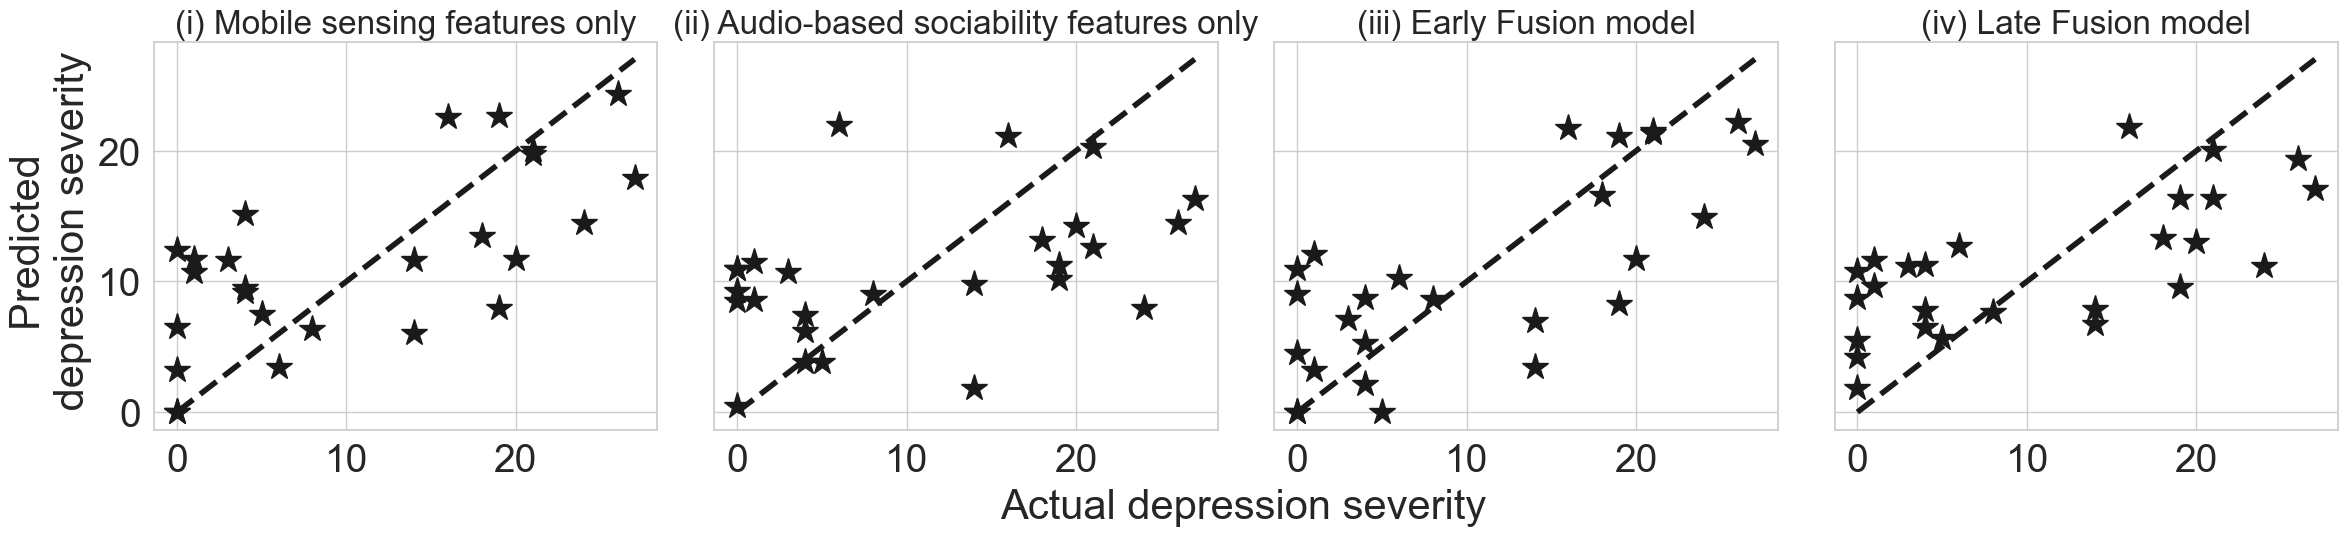

In [43]:
mobilesens_feat_data   = baylor_mobilesensing_feat_data[mobilesensing_feat_cols].copy()
mobilesens_label_data  = baylor_mobilesensing_feat_data['PHQ-sum'].copy()
mobilesens_subj        = baylor_mobilesensing_feat_data['subj'].copy()


print('Feature input dimension: {}'.format(mobilesens_feat_data.shape))

mobilesens_rmse_pred, mobilesens_rmse_pred_baseline, mobilesens_true_label_np, mobilesens_pred_label_np,\
    mobilesens_pred_baseline_label_np, mobilesens_test_subj_np, mobilesens_rmse_pred_low,\
    mobilesens_rmse_pred_high, mobilesens_all_clf = return_lopo_prediction(mobilesens_feat_data,
                                                                mobilesens_label_data,mobilesens_subj)

mobilesens_pred_corr_val, mobilesens_pred_corr_pval = pearsonr(mobilesens_true_label_np, mobilesens_pred_label_np)
mobilesens_rmse_pred_normalized = mobilesens_rmse_pred/(mobilesens_label_data.max() -\
                                                            mobilesens_label_data.min())
mobilesens_rmse_pred_baseline_normalized = mobilesens_rmse_pred_baseline/(mobilesens_label_data.max() -\
                                                            mobilesens_label_data.min())
    

print('RMSE of mobilesens prediction (feat:{}) is: {:.2f}/{:.2f}, - normalized {:.2f}/{:.2f},  corr {:.2f}(p={:.3f})'.format( mobilesens_feat_data.shape[1],
                                                                                        mobilesens_rmse_pred,
                                                                mobilesens_rmse_pred_baseline,mobilesens_rmse_pred_normalized,
                                                                        mobilesens_rmse_pred_baseline_normalized,
                                                                             mobilesens_pred_corr_val,
                                                                             mobilesens_pred_corr_pval))

#----------------------------------#


ipsn_feat = baylor_mobilesensing_feat_data[ipsn_variables_sel].copy()
ipsn_label= baylor_mobilesensing_feat_data['PHQ-sum'].copy()
ipsn_subj = baylor_mobilesensing_feat_data['subj'].copy()          

ipsn_rmse_pred, ipsn_rmse_pred_baseline, ipsn_true_label_np, ipsn_pred_label_np,\
    ipsn_pred_label_baseline_np, ipsn_test_subj_np, ipsn_rmse_pred_low,\
    ipsn_rmse_pred_high, ipsn_all_clf = return_lopo_prediction(ipsn_feat,
                                                                ipsn_label,
                                                                ipsn_subj)
ipsn_pred_corr_val, ipsn_pred_corr_pval = pearsonr(ipsn_true_label_np, ipsn_pred_label_np)
ipsn_rmse_pred_normalized = ipsn_rmse_pred/(ipsn_label.max() - ipsn_label.min())
    

print('RMSE of ipsn (feat:{}) prediction is: {:.2f}/{:.2f} - normalized {:.2f},  corr {:.2f}(p={:.3f})'.format(ipsn_feat.shape[1],
                                                           ipsn_rmse_pred,
                                                ipsn_rmse_pred_baseline, ipsn_rmse_pred_normalized,
                                                                                                ipsn_pred_corr_val, ipsn_pred_corr_pval))


mobilesens_ipsn_feat = baylor_mobilesensing_feat_data[mobilesens_ipsn_variables].copy()
mobilesens_ipsn_label= baylor_mobilesensing_feat_data['PHQ-sum'].copy()
mobilesens_ipsn_subj = baylor_mobilesensing_feat_data['subj'].copy()      

mobilesens_ipsn_rmse_pred, mobilesens_ipsn_rmse_pred_baseline, mobilesens_ipsn_true_label_np, mobilesens_ipsn_pred_label_np,\
    mobilesens_ipsn_pred_label_baseline_np, mobilesens_ipsn_test_subj_np, mobilesens_ipsn_rmse_pred_low,\
    mobilesens_ipsn_rmse_pred_high, mobilesens_ipsn_all_clf = return_lopo_prediction(mobilesens_ipsn_feat,
                                                                mobilesens_ipsn_label,
                                                                mobilesens_ipsn_subj)
mobilesens_ipsn_pred_corr_val, mobilesens_ipsn_pred_corr_pval = pearsonr(mobilesens_ipsn_true_label_np,
                                                                         mobilesens_ipsn_pred_label_np)
mobilesens_ipsn_rmse_pred_normalized = mobilesens_ipsn_rmse_pred/(mobilesens_ipsn_label.max() - mobilesens_ipsn_label.min())
   

print('RMSE of combined prediction (feat:{}) is: {:.2f}/{:.2f}, normalized: {:.2f}, corr: {:.2f}(p={:.3f})'.format(mobilesens_ipsn_feat.shape[1],
                                                            mobilesens_ipsn_rmse_pred,
                                                    mobilesens_ipsn_rmse_pred_baseline,
                                                        mobilesens_ipsn_rmse_pred_normalized,
                                                                                       mobilesens_ipsn_pred_corr_val,
                                                                               mobilesens_ipsn_pred_corr_pval))

mobilesens_ipsn_latefusion = (ipsn_pred_label_np+mobilesens_pred_label_np)/2
mobilesens_ipsn_latefusion_rmse = np.sqrt(mean_squared_error(ipsn_true_label_np,mobilesens_ipsn_latefusion))
mobilesens_ipsn_latefusion_pred_corr_val, mobilesens_ipsn_latefusion_pred_corr_pval = pearsonr(ipsn_true_label_np,
                                                                                               mobilesens_ipsn_latefusion)
mobilesens_ipsn_latefusion_rmse_normalized = mobilesens_ipsn_latefusion_rmse/(ipsn_label.max() - ipsn_label.min())
   

print('RMSE of latefusion prediction is: {:.2f}/{:.2f}, normalized: {:.2f}, corr: {:.2f}(p={:.3f})'.format( mobilesens_ipsn_latefusion_rmse,
                                                                               mobilesens_ipsn_rmse_pred_baseline,
                                                                               mobilesens_ipsn_latefusion_rmse_normalized,
                                                                mobilesens_ipsn_latefusion_pred_corr_val,
                                                                mobilesens_ipsn_latefusion_pred_corr_pval))


fig, ax = plt.subplots(1,4,figsize=(24,6),sharex=True,sharey=True)
print(pearsonr(mobilesens_ipsn_true_label_np,mobilesens_ipsn_pred_label_np))

markersize= 20
ax[0].plot(mobilesens_true_label_np,mobilesens_pred_label_np,'k*',linestyle='None',markersize=markersize)
ax[1].plot(ipsn_true_label_np,ipsn_pred_label_np,'k*',linestyle='None',markersize=markersize)
ax[2].plot(mobilesens_ipsn_true_label_np,mobilesens_ipsn_pred_label_np,'k*',linestyle='None',markersize=markersize)
ax[3].plot(mobilesens_ipsn_true_label_np,mobilesens_ipsn_latefusion,'k*',linestyle='None',markersize=markersize)

ax[0].plot(np.arange(0,28,1),np.arange(0,28,1),'k--',linewidth=4)
ax[1].plot(np.arange(0,28,1),np.arange(0,28,1),'k--',linewidth=4)
ax[2].plot(np.arange(0,28,1),np.arange(0,28,1),'k--',linewidth=4)
ax[3].plot(np.arange(0,28,1),np.arange(0,28,1),'k--',linewidth=4)

ax[0].set_ylabel('Predicted \n depression severity',fontsize=30)
ax[1].set_xlabel('Actual depression severity',fontsize=30)
ax[1].xaxis.set_label_coords(1.05, -0.15)


title_font_size = 24
ax[0].set_title('(i) Mobile sensing features only',fontsize=title_font_size)
ax[1].set_title('(ii) Audio-based sociability features only',fontsize=title_font_size)
ax[2].set_title('(iii) Early Fusion model',fontsize=title_font_size)
ax[3].set_title('(iv) Late Fusion model',fontsize=title_font_size)

for idx in np.arange(0,4):
    ax[idx].tick_params(axis='both', which='major', labelsize=title_font_size+4)
    ax[idx].tick_params(axis='both', which='minor', labelsize=title_font_size+4)

plt.tight_layout()


Depression Levels

0-4 : None [11 patients]
5-9 : Mild [3 patients]
10-14: Moderate [2 patients]
15-19: Moderately severe [4 patients]
20-27: Severe [6 patients]

### Depression severity classification

In [44]:
def map_phq_to_class(input_label):
    depression_range              = [0,5,10,15,20,28]
    depression_range_reducedclass = [0,15,28]
    
    return pd.cut(input_label, bins=depression_range,
                     right=False, labels=False)

In [45]:
def return_lopo_classification(feat_data,label_data,subj_data,                                  
                               fit_intercept=False,corr_p_thr=0.05):

    tune_alpha = True

    true_label = []
    pred_label = []
    pred_baseline_label = []
    subj_name  = []
    num_feat_selected = []

    for train_idx, test_idx in sel_split.split(feat_data,label_data):
        train_feat = feat_data.iloc[train_idx,:]
        test_feat  = feat_data.iloc[test_idx,:]
        
        train_label_= label_data.iloc[train_idx]
        test_label_  = label_data.iloc[test_idx]
        
        #map label to classes
        train_label = train_label_
        test_label  = test_label_
       
        test_subj  = subj_data[test_idx]
        
        #fill nan if any
        train_feat_  = imputer_knn.fit_transform(train_feat)
        test_feat_   = imputer_knn.transform(test_feat)
        train_feat   = pd.DataFrame(train_feat_,index=train_feat.index,columns=train_feat.columns)
        test_feat    = pd.DataFrame(test_feat_,index=test_feat.index,columns=test_feat.columns)
        
        
        if(tune_alpha):
            inner_true_all = []
            inner_pred_all = []

            all_alpha_res = {}
            for alpha in np.logspace(0,3,21):

                for inner_train_idx, inner_test_idx in KFold(n_splits=5).split(train_feat,train_label):
                    inner_train_feat, inner_train_label = train_feat.iloc[inner_train_idx,:], train_label.iloc[inner_train_idx]
                    inner_test_feat, inner_test_label = train_feat.iloc[inner_test_idx,:], train_label.iloc[inner_test_idx]

                    if( len(np.setdiff1d(np.unique(train_label),np.unique(inner_train_label))) > 0):
                        continue

                    sel_clf = LogisticAT(alpha=alpha)
                    sel_clf.fit(inner_train_feat,inner_train_label)

                    inner_pred = sel_clf.predict(inner_test_feat)

                    inner_true_all.append(inner_test_label)
                    inner_pred_all.append(inner_pred)

                inner_true_label_np = np.concatenate(inner_true_all)
                inner_pred_label_np = np.concatenate(inner_pred_all)

                f1_pred          = fbeta_score(inner_true_label_np,inner_pred_label_np,beta=1,
                                               average='weighted')

                all_alpha_res[alpha] = f1_pred

            all_alpha_res_pd = pd.Series(all_alpha_res).sort_values()
            best_alpha       = all_alpha_res_pd.index[-1]
            #print(best_alpha,all_alpha_res_pd.iloc[-1],all_alpha_res_pd.iloc[0])
            sel_clf = LogisticAT(alpha=best_alpha)
        else:        
            sel_clf = LogisticAT() #LogisticAT(alpha=best_alpha)
        
        sel_clf.fit(train_feat,train_label)
        num_feat_selected.append(train_feat.shape[1])
        pred_ = sel_clf.predict(test_feat)
      
        #assert(len(pred_)==1)
        pred_ = pred_
        
        true_label.append(test_label)
        pred_label.append(pred_)
        baseline_class = train_label.value_counts().index[0]
        pred_baseline_label.append([baseline_class])
        subj_name.append(test_subj)
        

    true_label_np = np.concatenate(true_label)
    pred_label_np = np.concatenate(pred_label)
        
    pred_baseline_label_np = np.concatenate(pred_baseline_label)
    test_subj_np  = np.concatenate(subj_name)

    f1_pred          = fbeta_score(true_label_np,pred_label_np,beta=1,
                                   average='weighted')
    f1_pred_baseline = fbeta_score(true_label_np,pred_baseline_label_np,beta=1,
                                  average='weighted')
    
    
    return f1_pred, f1_pred_baseline, true_label_np, pred_label_np, pred_baseline_label_np, test_subj_np

In [46]:
start_time = time.time()

mobilesensing_feat_cols = np.setdiff1d(np.union1d(np.union1d(np.union1d(call_feat_cols_sel,sms_feat_cols_sel),
                                     callsms_feat_cols_sel),loc_feat_cols_sel),['num_days'])

mobilesens_feat_data   = baylor_mobilesensing_feat_data[mobilesensing_feat_cols].copy()
mobilesens_label_data  = baylor_mobilesensing_feat_data['PHQ-sum'].copy() 
mobilesens_subj        = baylor_mobilesensing_feat_data['subj'].copy()

mobilesens_label_data_class = map_phq_to_class(mobilesens_label_data)

print('Num data per class: {}'.format(pd.Series(mobilesens_label_data_class).value_counts().sort_index().values))

print('\n Feature input dimension mobile sensing only: {}'.format(mobilesens_feat_data.shape))

mobilesens_f1_pred, mobilesens_f1_pred_baseline, mobilesens_true_label_np, mobilesens_pred_label_np,\
    mobilesens_pred_baseline_label_np, mobilesens_test_subj_np = return_lopo_classification(mobilesens_feat_data,
                                                                mobilesens_label_data_class,mobilesens_subj)

print('F1 of mobilesens prediction is: {}/{}'.format( mobilesens_f1_pred, mobilesens_f1_pred_baseline ))

print('Time elapsed: {}'.format(time.time()-start_time))

mobilesens_mae_pred = mean_absolute_error(mobilesens_true_label_np,
                                         mobilesens_pred_label_np)
mobilesens_mae_pred_baseline = mean_absolute_error(mobilesens_true_label_np,
                                         mobilesens_pred_baseline_label_np)
print('Mobilesens MAE: {}/{}'.format(mobilesens_mae_pred,
                                     mobilesens_mae_pred_baseline))

#----------------------------------#

ipsn_feat = baylor_mobilesensing_feat_data[ipsn_variables_sel].copy()
ipsn_label= baylor_mobilesensing_feat_data['PHQ-sum'].copy()
ipsn_subj = baylor_mobilesensing_feat_data['subj'].copy()          

ipsn_label_class = map_phq_to_class(ipsn_label)

print('\n Feature input dimension IPSN only: {}'.format(ipsn_feat.shape))


ipsn_f1_pred, ipsn_f1_pred_baseline, ipsn_true_label_np, ipsn_pred_label_np,\
    ipsn_pred_label_baseline_np, ipsn_test_subj_np = return_lopo_classification(ipsn_feat,
                                                                ipsn_label_class,
                                                                ipsn_subj)
print('F1 of ipsn prediction is: {}/{}'.format(ipsn_f1_pred, ipsn_f1_pred_baseline))

print('Time elapsed: {}'.format(time.time()-start_time))

ipsn_mae_pred = mean_absolute_error(ipsn_true_label_np,
                                         ipsn_pred_label_np)
ipsn_mae_pred_baseline = mean_absolute_error(ipsn_true_label_np,
                                         ipsn_pred_label_baseline_np)
print('IPSN MAE: {}/{}'.format(ipsn_mae_pred,
                                     ipsn_mae_pred_baseline))


mobilesens_ipsn_variables = np.union1d(mobilesensing_feat_cols, ipsn_variables_sel)

mobilesens_ipsn_feat = baylor_mobilesensing_feat_data[mobilesens_ipsn_variables].copy()
mobilesens_ipsn_label= baylor_mobilesensing_feat_data['PHQ-sum'].copy()
mobilesens_ipsn_subj = baylor_mobilesensing_feat_data['subj'].copy()      

mobilesens_ipsn_label_class = map_phq_to_class(mobilesens_ipsn_label)

print('\n Feat dimension (mobilesensing + ipsn) is: {}'.format(mobilesens_ipsn_feat.shape))

mobilesens_ipsn_f1_pred, mobilesens_ipsn_f1_pred_baseline, mobilesens_ipsn_true_label_np, mobilesens_ipsn_pred_label_np,\
    mobilesens_ipsn_pred_label_baseline_np, mobilesens_ipsn_test_subj_np = return_lopo_classification(mobilesens_ipsn_feat,
                                                                mobilesens_ipsn_label_class,
                                                                mobilesens_ipsn_subj)
print('F1 of combined prediction is: {}/{}'.format( mobilesens_ipsn_f1_pred, mobilesens_ipsn_f1_pred_baseline))



mobilesens_ipsn_mae_pred = mean_absolute_error(mobilesens_ipsn_true_label_np,
                                         mobilesens_ipsn_pred_label_np)
mobilesens_ipsn_mae_pred_baseline = mean_absolute_error(mobilesens_ipsn_true_label_np,
                                         mobilesens_ipsn_pred_label_baseline_np)
print('Mobilesens IPSN MAE: {}/{}'.format(mobilesens_ipsn_mae_pred,
                                     mobilesens_ipsn_mae_pred_baseline))

print('\n \n ==> F1 for Baseline: {:.2f}, mobilesens: {:.2f}, audio: {:.2f}, mobilesens+audio: {:.2f}'.format(mobilesens_f1_pred_baseline,
                                                mobilesens_f1_pred, ipsn_f1_pred, mobilesens_ipsn_f1_pred ))


Num data per class: [11  3  2  4  6]

 Feature input dimension mobile sensing only: (26, 19)
F1 of mobilesens prediction is: 0.34019664545980344/0.2515592515592515
Time elapsed: 600.2789413928986
Mobilesens MAE: 1.3846153846153846/1.6538461538461537

 Feature input dimension IPSN only: (26, 3)
F1 of ipsn prediction is: 0.33931623931623933/0.2515592515592515
Time elapsed: 710.2388949394226
IPSN MAE: 1.1538461538461537/1.6538461538461537

 Feat dimension (mobilesensing + ipsn) is: (26, 22)
F1 of combined prediction is: 0.4562937062937063/0.2515592515592515
Mobilesens IPSN MAE: 1.0769230769230769/1.6538461538461537

 
 ==> F1 for Baseline: 0.25, mobilesens: 0.34, audio: 0.34, mobilesens+audio: 0.46
